In [1]:
import codigo
from codigo import utils
from codigo import model_LSTM
from codigo import model_utils
from cg_ega.cg_ega import CG_EGA

In [2]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
modeloBasePath='modelos/modeloGeneral/bidirectional_dropout.h5'
modeloSave='/transfer_bidirectional_dropout_completo.h5'

In [5]:
balanceo=''

In [6]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

In [7]:
paciente='paciente1'

In [8]:
with open('dataset/generado/'+paciente+'/array_Xtrain'+balanceo+'.npy', 'rb') as f:
    array_Xtrain = np.load(f)

In [9]:
len(array_Xtrain)

1523

In [10]:
with open('dataset/generado/'+paciente+'/array_Ytrain'+balanceo+'.npy', 'rb') as f:
    array_Ytrain = np.load(f)

In [11]:
len(array_Ytrain)

1523

In [12]:
with open('dataset/generado/'+paciente+'/array_Xval'+balanceo+'.npy', 'rb') as f:
    array_Xval = np.load(f)

In [13]:
len(array_Xval)

190

In [14]:
with open('dataset/generado/'+paciente+'/array_Yval'+balanceo+'.npy', 'rb') as f:
    array_Yval = np.load(f)

In [15]:
len(array_Yval)

190

In [16]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [17]:
len(array_Xtest)

191

In [18]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [19]:
len(array_Ytest)

191

In [20]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=3, min_delta=0.001)

# Rendimiento del Modelo base

In [21]:
base_model = keras.models.load_model(modeloBasePath)

6/6 [==============================] - 1s 11ms/step


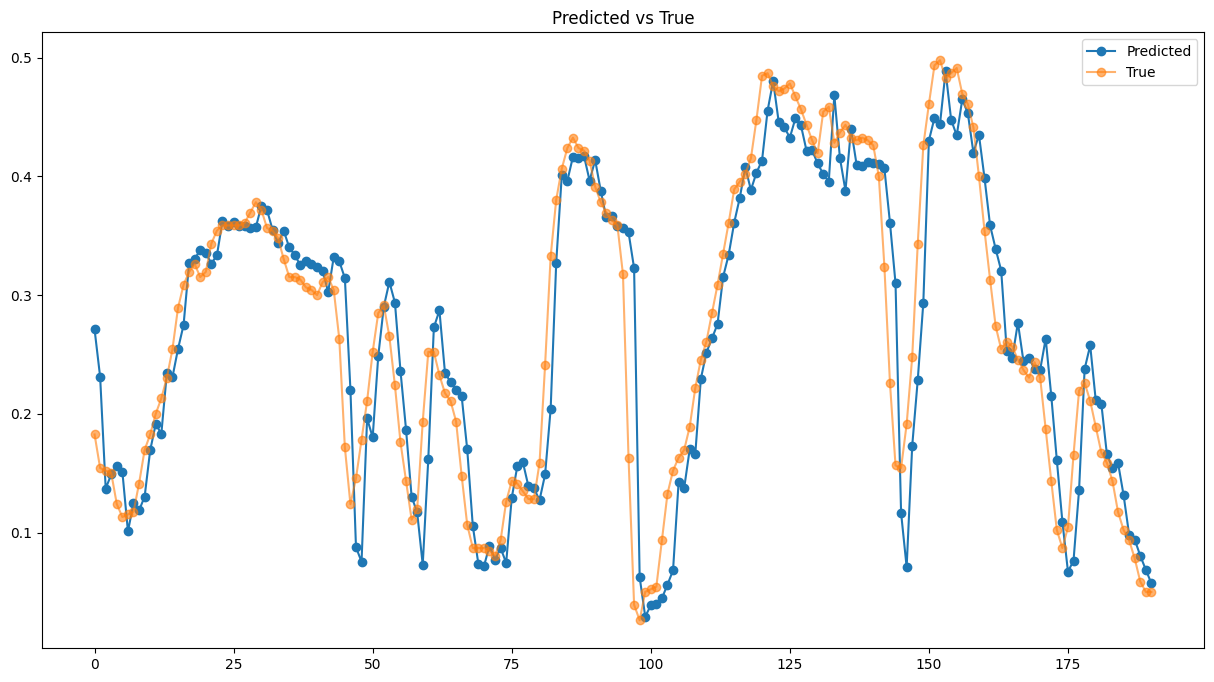

In [22]:
yhat = base_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [23]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.03516492638851445,
 'mse': 0.051523845400699056,
 'rmse': 0.0026547066448751374}

# Iniciamos transfer learning

In [24]:
base_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 64)               9728      
 l)                                                              
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                      

In [25]:
base_model.layers[-2].output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dropout_8')>

In [26]:
transferModel=model_LSTM.transferLearning_NewModel(base_model,-3,False,True)
transferModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_input (InputL  [(None, 30, 5)]          0         
 ayer)                                                           
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9728      
 l)                                                              
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080  

In [27]:
array_Xtrain.shape

(1523, 30, 5)

In [28]:
transferModel.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae','mse'])

history =transferModel.fit(array_Xtrain, array_Ytrain,epochs=epochs, validation_data=(array_Xval, array_Yval), shuffle=False, callbacks=[early_stopping])
transferModel.save('modelos/'+paciente+modeloSave)

Epoch 1/100
48/48 [==============================] - 6s 36ms/step - loss: 0.0208 - mae: 0.1086 - mse: 0.0208 - val_loss: 0.0038 - val_mae: 0.0505 - val_mse: 0.0038
Epoch 2/100
48/48 [==============================] - 1s 17ms/step - loss: 0.0039 - mae: 0.0478 - mse: 0.0039 - val_loss: 0.0026 - val_mae: 0.0390 - val_mse: 0.0026
Epoch 3/100
48/48 [==============================] - 1s 17ms/step - loss: 0.0034 - mae: 0.0443 - mse: 0.0034 - val_loss: 0.0025 - val_mae: 0.0363 - val_mse: 0.0025
Epoch 4/100
48/48 [==============================] - 1s 16ms/step - loss: 0.0032 - mae: 0.0428 - mse: 0.0032 - val_loss: 0.0024 - val_mae: 0.0358 - val_mse: 0.0024
Epoch 5/100
48/48 [==============================] - 1s 16ms/step - loss: 0.0032 - mae: 0.0424 - mse: 0.0032 - val_loss: 0.0024 - val_mae: 0.0360 - val_mse: 0.0024
Epoch 6/100
48/48 [==============================] - 1s 16ms/step - loss: 0.0031 - mae: 0.0420 - mse: 0.0031 - val_loss: 0.0025 - val_mae: 0.0362 - val_mse: 0.0025


6/6 [==============================] - 0s 12ms/step - loss: 0.0028 - mae: 0.0428 - mse: 0.0028
test loss, test acc: [0.0028193520847707987, 0.04275420680642128, 0.0028193520847707987]


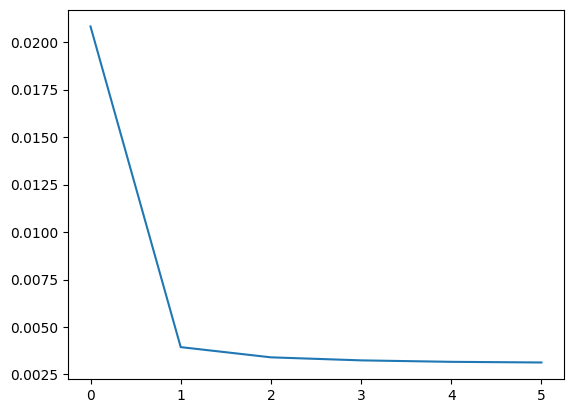

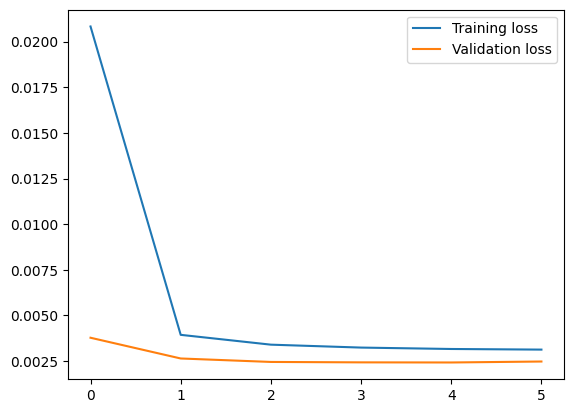

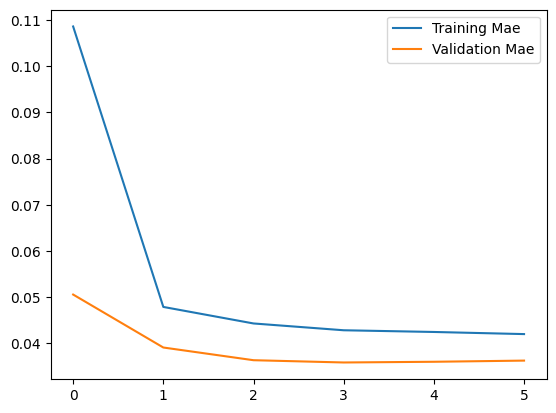

In [29]:
model_utils.modelEvaluateTraining(transferModel,history,array_Xtest, array_Ytest)

6/6 [==============================] - 0s 5ms/step


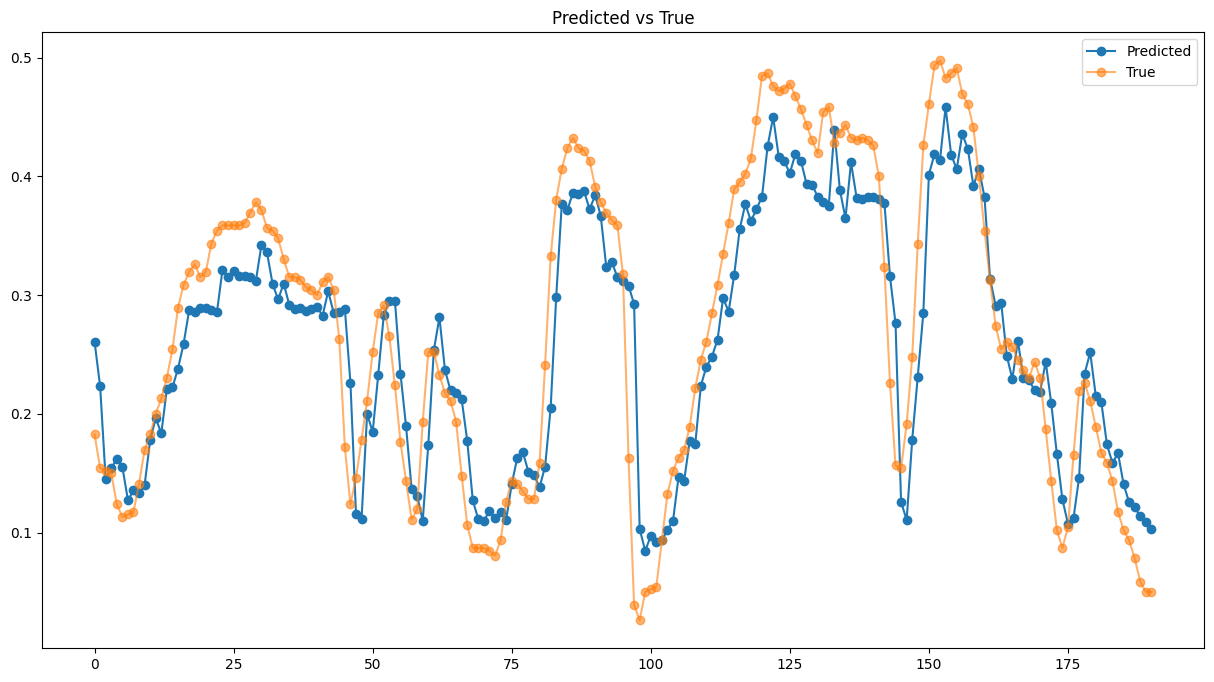

In [30]:
yhat = transferModel.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [31]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.04275420395016751,
 'mse': 0.053097571254683756,
 'rmse': 0.0028193520731462185}

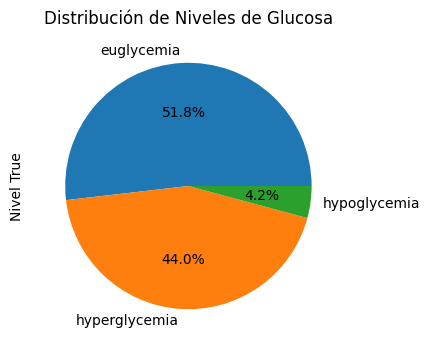

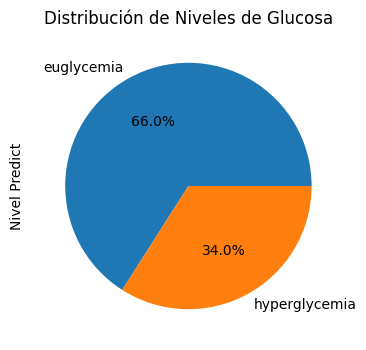

,Glucose level True,Nivel True,Glucose level Predict,Nivel Predict
0,124.0,euglycemia,159.974548,euglycemia
1,111.0,euglycemia,142.651382,euglycemia
2,110.0,euglycemia,106.569626,euglycemia
3,109.0,euglycemia,110.890656,euglycemia
4,97.0,euglycemia,114.553207,euglycemia


In [32]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


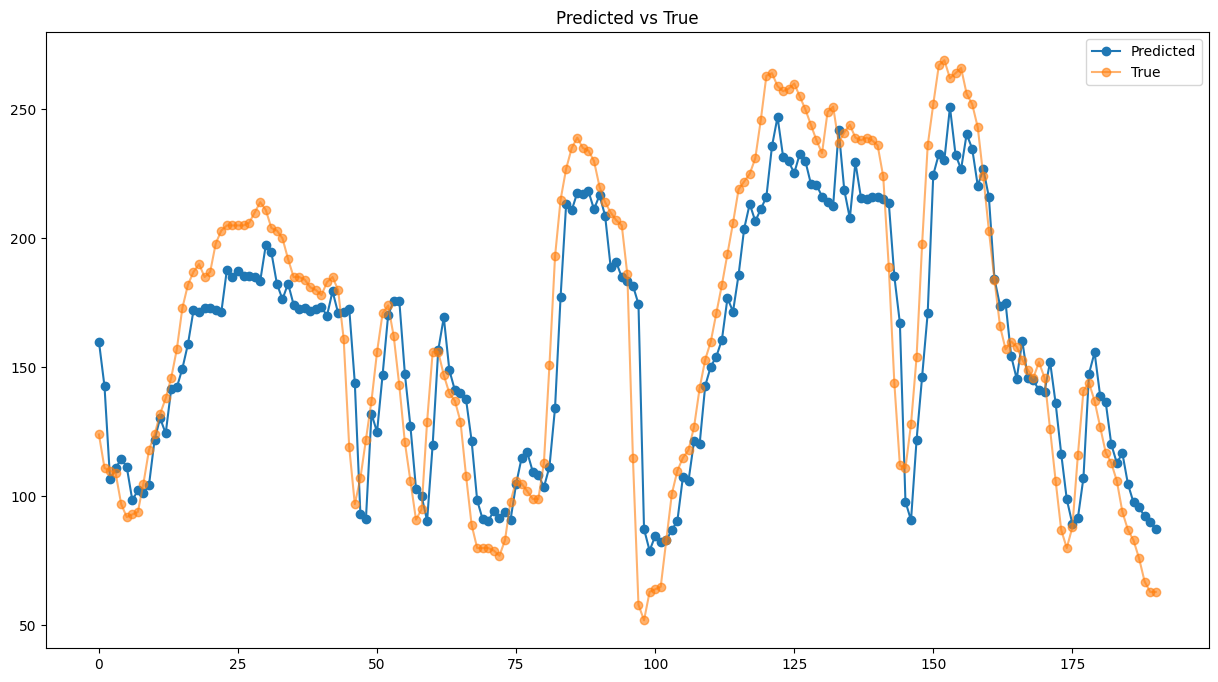

{'mae': 19.66693247051139,
 'mse': 24.424881906552248,
 'rmse': 596.5748561490233}

In [33]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [34]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=df_glucose['Glucose level True']
dfPlot['y_pred']=df_glucose['Glucose level Predict']
dfPlot.index=pd.date_range("2023-01-01", periods=len(df_glucose['Glucose level True']), freq="15min")
dfPlot

,y_true,y_pred
2023-01-01 00:00:00,124.0,159.974548
2023-01-01 00:15:00,111.0,142.651382
2023-01-01 00:30:00,110.0,106.569626
2023-01-01 00:45:00,109.0,110.890656
2023-01-01 01:00:00,97.0,114.553207
...,...,...
2023-01-02 22:30:00,83.0,97.645187
2023-01-02 22:45:00,76.0,95.786491
2023-01-02 23:00:00,67.0,92.275368
2023-01-02 23:15:00,63.0,90.028549


AP, BE, EP: (0.9, 0.05789473684210526, 0.042105263157894736)


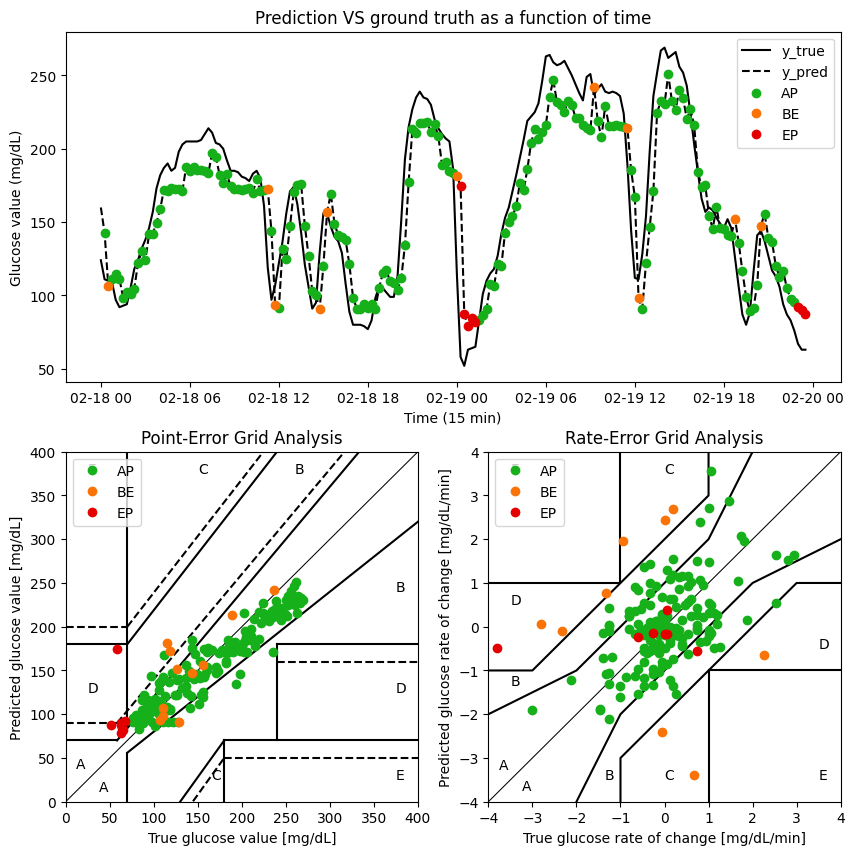

In [35]:
freq = 15
cg_ega = CG_EGA(dfPlot, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)